In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [2]:
df = pd.read_csv('../vb_data/agg_stations.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 4 columns):
update       1006 non-null object
free         1006 non-null int64
available    1006 non-null int64
total        1006 non-null int64
dtypes: int64(3), object(1)
memory usage: 31.5+ KB


In [11]:
df['update'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['update']]

In [12]:
df.set_index('update', inplace = True)

Our season will be comprised of (24*4) observations, since this is quarter hourly data we can see that every cycle seems more or less to happen over one day. This also makes intuitive sense because 96 quarter hours make one day

In [37]:
24*4

96

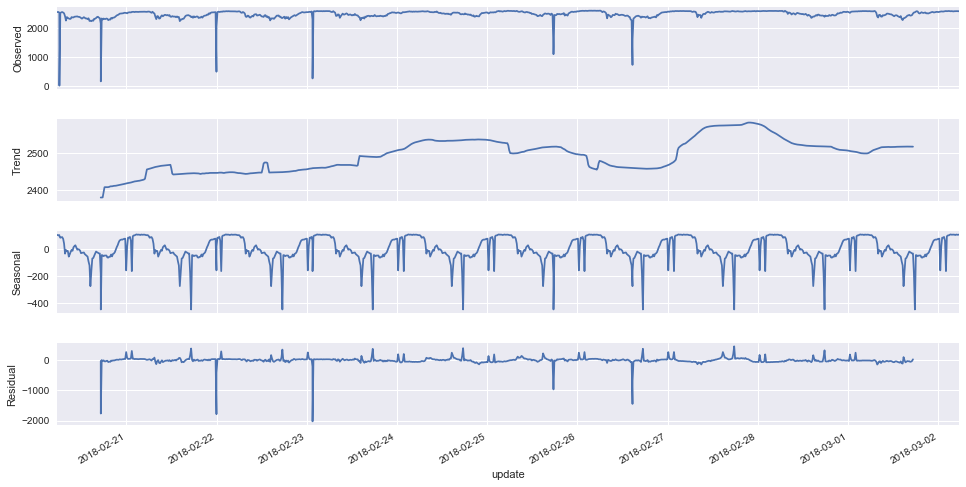

In [38]:
decomposition = seasonal_decompose(df[0:960].available, freq=96)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

### Dickey-Fuller: empirical method of evaluating whether we've achieved stationarity.
The null hypothesis is that it is not stationary, the alternative hypothesis is that it is stationary. If we reject our null-hypothesis, then we are saying that our timeseries is already stationary and does not need to be differenced. If we fail to reject it, then our timeseries is not stationary, and does need to be differenced.

In [40]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=96)
    rolstd = pd.rolling_std(timeseries, window=96)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).mean()
/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).std()


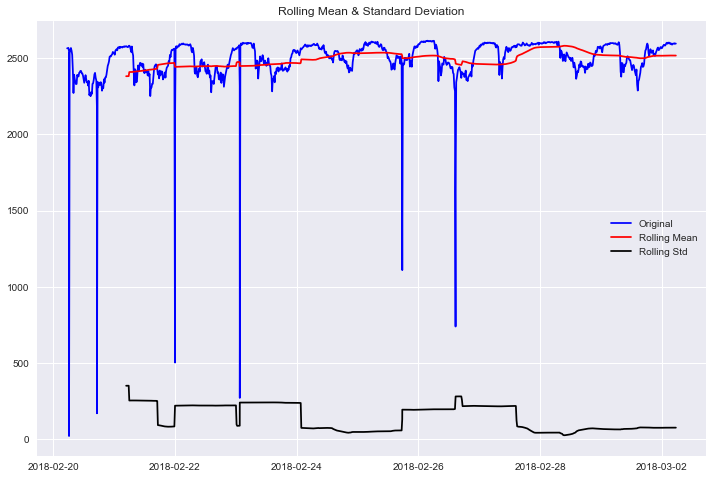

Results of Dickey-Fuller Test:
Test Statistic                -6.448176e+00
p-value                        1.547063e-08
#Lags Used                     8.000000e+00
Number of Observations Used    9.510000e+02
Critical Value (1%)           -3.437245e+00
Critical Value (10%)          -2.568391e+00
Critical Value (5%)           -2.864584e+00
dtype: float64


In [42]:
test_stationarity(df[0:960].available)

/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).mean()
/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).std()


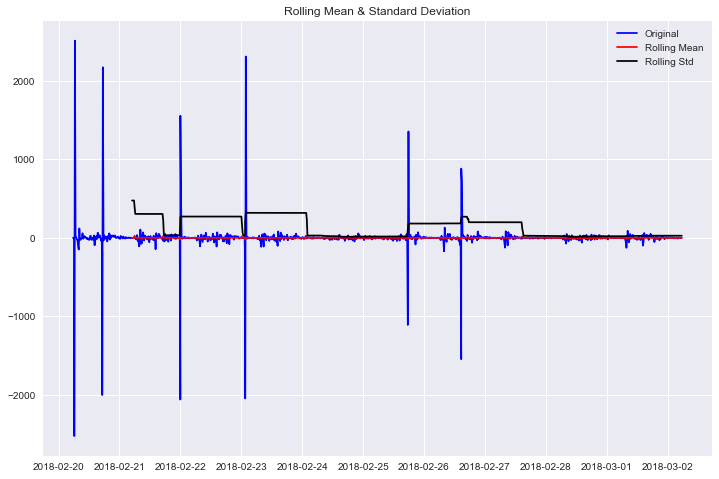

Results of Dickey-Fuller Test:
Test Statistic                -1.309785e+01
p-value                        1.734414e-24
#Lags Used                     1.300000e+01
Number of Observations Used    9.450000e+02
Critical Value (1%)           -3.437289e+00
Critical Value (10%)          -2.568401e+00
Critical Value (5%)           -2.864603e+00
dtype: float64


In [44]:
df['first_difference'] = df[0:960].available - df[0:960].available.shift(1)  
test_stationarity(df.first_difference.dropna(inplace=False))

/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).mean()
/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).std()


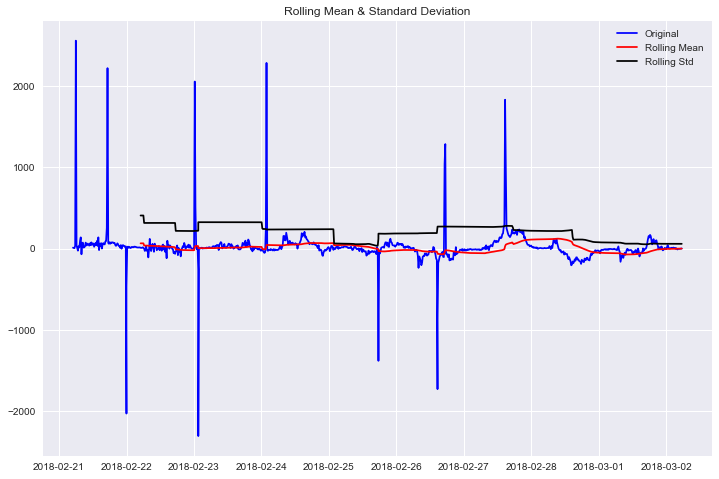

Results of Dickey-Fuller Test:
Test Statistic                -9.302529e+00
p-value                        1.102647e-15
#Lags Used                     6.000000e+00
Number of Observations Used    8.570000e+02
Critical Value (1%)           -3.438003e+00
Critical Value (10%)          -2.568569e+00
Critical Value (5%)           -2.864918e+00
dtype: float64


In [46]:
df['seasonal_difference'] = df[0:960].available - df[0:960].available.shift(96)
test_stationarity(df.seasonal_difference.dropna(inplace=False))

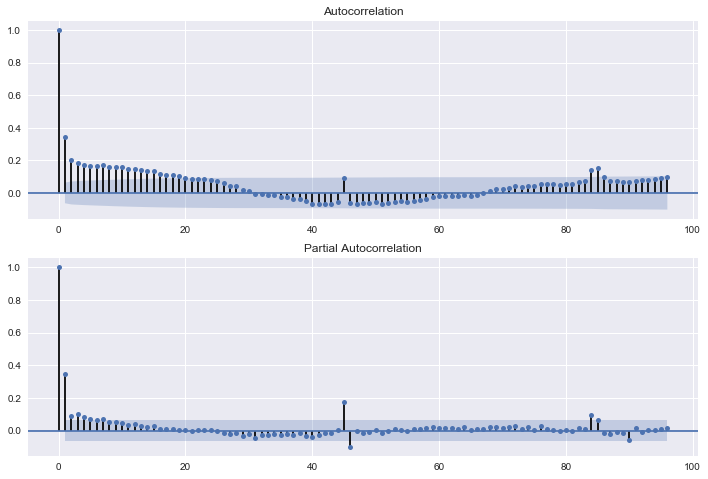

In [47]:
# What we actually want to do is plot the autocorrelation plots of our de-trended, stationary data
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df[0:960].available, lags=96, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df[0:960].available, lags=96, ax=ax2)

In [48]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(1,0,0), seasonal_order=(0,1,1,24))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(1, 0, 0)x(0, 1, 1, 24)   Log Likelihood               -6216.252
Date:                            Mon, 12 Mar 2018   AIC                          12438.504
Time:                                    00:16:53   BIC                          12453.105
Sample:                                02-20-2018   HQIC                         12444.064
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3333      0.011     30.700      0.000       0.312       0.355
ma.S.L24      -0.8979      0.016    -56.479      0.000      -0.929      -0.867
sigma2      3.244e+04    447.806     72.450      0.000    3.16e+04    3.33e+04
===================================================================================
Ljung-Box (Q):                       91.65   Jarque-Bera (JB):            159029.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -3.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        66.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(1,0,0), seasonal_order=(0,1,7,24), enforce_invertibility = False)
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(1, 0, 0)x(0, 1, 7, 24)   Log Likelihood               -6202.174
Date:                            Mon, 12 Mar 2018   AIC                          12422.348
Time:                                    21:18:45   BIC                          12466.150
Sample:                                02-20-2018   HQIC                         12439.028
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3109      0.011     27.056      0.000       0.288       0.333
ma.S.L24      -0.8459      0.017    -49.417      0.000      -0.879      -0.812
ma.S.L48      -0.0981      0.017     -5.632      0.000      -0.132      -0.064
ma.S.L72       0.0648      0.018      3.546      0.000       0.029       0.101
ma.S.L96      -0.0156      0.023     -0.689      0.491      -0.060       0.029
ma.S.L120     -0.0456      0.032     -1.419      0.156      -0.109       0.017
ma.S.L144     -0.0541      0.045     -1.215      0.224      -0.141       0.033
ma.S.L168      0.1613      0.024      6.714      0.000       0.114       0.208
sigma2      3.146e+04    364.051     86.422      0.000    3.07e+04    3.22e+04
===================================================================================
Ljung-Box (Q):                       76.12   Jarque-Bera (JB):            156228.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -3.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        65.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(1,0,0), seasonal_order=(1,7,24,4), enforce_invertibility = False)
results = mod.fit()
results.summary()

/Users/nmolivo/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/nmolivo/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/nmolivo/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/nmolivo/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/nmolivo/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(1, 0, 0)x(1, 7, 24, 4)   Log Likelihood              -12684.763
Date:                            Mon, 12 Mar 2018   AIC                          25423.527
Time:                                    23:22:47   BIC                          25554.934
Sample:                                02-20-2018   HQIC                         25473.570
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2512      1.439      0.175      0.861      -2.569       3.071
ar.S.L4       -0.8705     28.360     -0.031      0.976     -56.456      54.715
ma.S.L4       -4.8760     25.569     -0.191      0.849     -54.990      45.238
ma.S.L8        8.7565    143.122      0.061      0.951    -271.757     289.270
ma.S.L12      -7.2354    331.000     -0.022      0.983    -655.984     641.513
ma.S.L16      -0.4233    445.232     -0.001      0.999    -873.061     872.215
ma.S.L20       5.6047    362.975      0.015      0.988    -705.813     717.022
ma.S.L24      -5.3968    279.263     -0.019      0.985    -552.741     541.948
ma.S.L28       1.7069    511.808      0.003      0.997   -1001.419    1004.833
ma.S.L32      -0.6063    647.186     -0.001      0.999   -1269.068    1267.856
ma.S.L36      -0.1571    500.427     -0.000      1.000    -980.976     980.662
ma.S.L40      -0.5550    393.284     -0.001      0.999    -771.377     770.267
ma.S.L44      -0.4679    517.958     -0.001      0.999   -1015.648    1014.712
ma.S.L48      -0.1848    472.562     -0.000      1.000    -926.389     926.019
ma.S.L52      -0.5990    277.639     -0.002      0.998    -544.761     543.563
ma.S.L56      -0.2099    165.508     -0.001      0.999    -324.599     324.179
ma.S.L60      -0.3056    137.165     -0.002      0.998    -269.145     268.533
ma.S.L64      -0.6855    122.815     -0.006      0.996    -241.398     240.027
ma.S.L68      -0.1405    132.220     -0.001      0.999    -259.288     259.007
ma.S.L72      -0.1796    128.075     -0.001      0.999    -251.202     250.842
ma.S.L76      -0.3326    105.885     -0.003      0.997    -207.864     207.199
ma.S.L80      -0.0296     91.751     -0.000      1.000    -179.859     179.800
ma.S.L84      -0.0915     91.117     -0.001      0.999    -178.677     178.494
ma.S.L88      -0.9360     66.686     -0.014      0.989    -131.639     129.767
ma.S.L92       1.0631     40.929      0.026      0.979     -79.157      81.283
ma.S.L96      -0.6392     16.618     -0.038      0.969     -33.209      31.931
sigma2      7.465e+07        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                     3245.10   Jarque-Bera (JB):               607.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.04
Prob(H) (two-sided):                  0.07   Kurtosis:                         6.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.81e+30. Standard errors may be unstable.
"""